# Project Proposal: Exploring Pulsar Star Data

Introduction
----

<b>Relevant Background<b>
    
Pulsar stars are a type of Neutron star that produces radio emission detectable on Earth. They are significant as they are used as probes of space-time, the interstellar medium, and states of matter (1).
    
Light emitted by a pulsar contains information about the physics of Neutron stars, which are the densest material in the universe. The precise blink or pulse of a pulsar star can indicate a possible event happening in space, as well. Cosmic distances can be calculated due to the regular periodicity of pulsar stars' light emission and they have been used to test parts of the theory of relativity (2).

<b>Research Question<b>
    
    How accurately can the Integrated Pulse Profile determine if a star is pulsar or non-pulsar?


<b>About the Dataset<b>

To answer the question of how effective the Integrated Pulse Profile is at determining whether a star is pulsar, the Pulsar Dataset https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2 will be used. The data in the Pulsar Dataset was collected through the High Time Resolution Universe Survey. 
    
This dataset uses the mean, standard deviation, excess kurtosis, and skewness of the stars’ integrated profiles and DM-SNR curves to classify whether or not a star can be identified as a pulsar. 
    
<u>DM-SNR curves:</u>
    measure the radio waves released by pulsar stars once they reach Earth and have already traveled long distances in space surrounded by free electrons.
    
<u>Integrated Pulse Profile</u>: used to identify the pulsar as each profile is unique;however, pulse profiles vary slightly each period due to their signals being  non uniform and unstable. Averaged over many  thousands of rotations makes the profiles stable.

<u> Excess Kurtosis</u>: means that the distribution of event outcomes have many outliers leading to fat tails on the bell shaped distribution curve. 
    
The observations under the Class variable are binary, indicating that a star is a pulsar or non-pulsar. It is for this reason that the Class variable has been converted to a factor, as the observations are discrete. The rest of the variables are continuous values (1).

Exploratory Data Analysis
----

In [1]:
#1. Download libraries

library(tidyverse)
library(repr)
library(tidymodels)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#2.Read in data Pulsar Star Data

pulsar_star_data<-read_csv("https://raw.githubusercontent.com/madisongill/dsci-100-2023s-group-39-section-002/main/HTRU_2.csv",col_names=FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#3. Tidy data (add column names,condense if needed,

pulsar <- pulsar_star_data|>
rename(mean=X1,
       std_dev=X2,
       kurt=X3,
       skew=X4,
       mean_dmsnr=X5,
       std_dev_dmsnr=X6,
       kurt_dmsnr=X7,
       skew_dmsnr=X8,
       class=X9) |>
mutate(class = as_factor(class))  

In [4]:
#4.Split data into training and test set

pulsar_split<-initial_split(pulsar,prop=0.75,strata=class)
pulsar_train<-training(pulsar_split)
pulsar_test<-testing(pulsar_split)

<b>Summarizing and Visualizing the Data

The next code cell reduces the columns to be used, and summarizes their values. A count of each class is shown, as well as the average of each column and a count of missing values.

In [10]:
reduced_train <- pulsar_train |>
    select(-(mean_dmsnr:skew_dmsnr)) #selecting for only integrated profile values

class_count <- reduced_train |> #summarize counts of class labels
    group_by(class) |>
    summarize(count = n()) 

summary_train <- reduced_train |> #the average of all the predictor variables
    select(-class) |>
    map_df(mean) |>
    rename(mean_avg = mean,
           std_dev_avg = std_dev, 
           kurt_avg = kurt,
           skew_avg = skew)

check_na <- as_tibble(sum(is.na(reduced_train))) |> #checking for na values
    rename(missing_vals = value)

total_summary <- cbind(summary_train, check_na) #combine summary_train and check_na into one df

total_summary
class_count

mean_avg,std_dev_avg,kurt_avg,skew_avg,missing_vals
<dbl>,<dbl>,<dbl>,<dbl>,<int>
111.1363,46.56378,0.4749385,1.757917,0


class,count
<fct>,<int>
0,12200
1,1223


The following plot is an example of one way the research question can be answered. Using information from the stars' integrated profiles, a relationship can be seen between the excess kurtosis and mean. It appears to be a strong negative linear relationship, with higher values of mean and lower values of excess kurtosis correlating to non-pulsar stars.

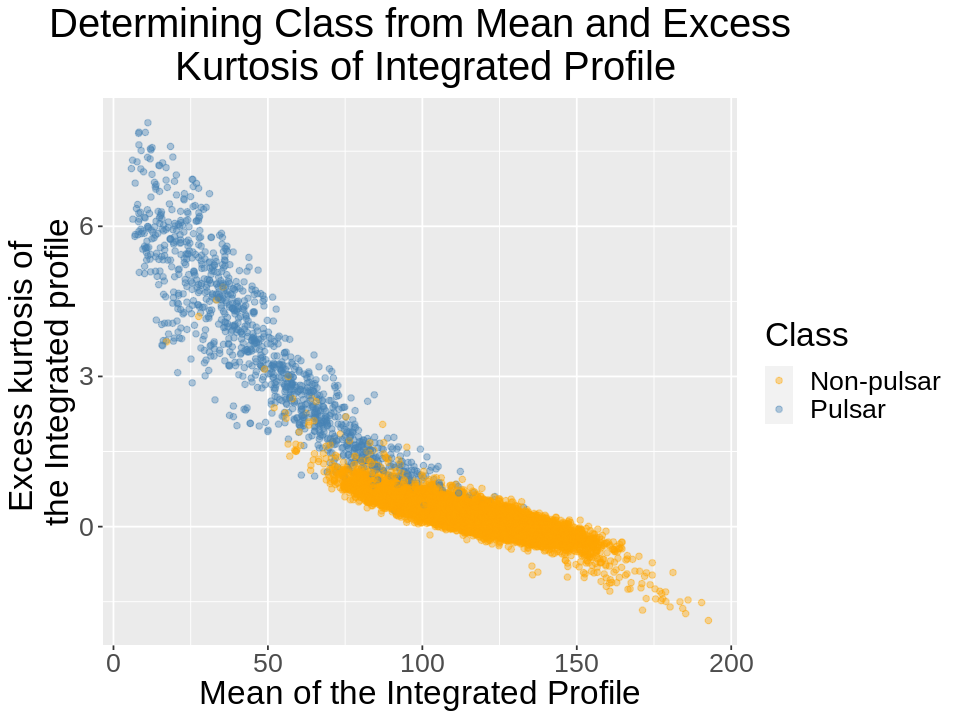

In [6]:
options(repr.plot.width = 8, repr.plot.height = 6)

pulsar_star_graph <- pulsar_train |>
ggplot(aes(x = mean, y = kurt, color = class)) +
geom_point(alpha = 0.4) +

labs(x = "Mean of the Integrated Profile", y = "Excess kurtosis of \nthe Integrated profile", color = "Class") +
scale_color_manual(labels = c("Non-pulsar", "Pulsar"),
                   values = c("orange", "steel blue")) +
ggtitle("Determining Class from Mean and Excess\n Kurtosis of Integrated Profile")+
theme(plot.title = element_text(hjust = 0.5))+
theme(text = element_text(size = 20))

pulsar_star_graph

Methods
----


Significance
----